In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from utils import *

## simulate test data

In [2]:
class TwoArmLinkTestDataset(Dataset):
	def __init__(self, n_tasks=100, n_episode=1, n_timesteps=200) -> None:
		super().__init__()
		self.l = []
		self.adapt = {
			'q':[],
			'x':[],
			'z':[]}
		self.test = {
			'q0':[],
			'xg':[],
			'x':[],
			'z':[],
		}
		l_of_tasks = np.random.normal(loc=1, scale=0.3, size=(n_tasks,2))
		for i in tqdm(range(n_tasks)):
			l = l_of_tasks[i]
			self.l.append(l)
			for j in range(n_episode):
				# generate motor babbling
				q, x, z = generate_motor_babbling_episode(l, n_timesteps)
				self.adapt['q'].append(q)
				self.adapt['x'].append(x)
				self.adapt['z'].append(z)
				# generate pd control
				q_0, x_g, x, z = generate_pd_control_episode(l, n_timesteps)
				self.test['q0'].append(q_0)
				self.test['xg'].append(x_g)
				self.test['x'].append(x)
				self.test['z'].append(z)

	def __getitem__(self, index):
		sample = {
		'adapt':{
			'angle': torch.tensor(self.adapt['q'][index]),
			'true_pos': torch.tensor(self.adapt['x'][index]),
			'noisy_pos': torch.tensor(self.adapt['z'][index]),
		},
		'test': {
			"init_angle": torch.tensor(self.test['q0'][index]),
			"target_pos": torch.tensor(self.test['xg'][index]),
			"true_pos": torch.tensor(self.test['x'][index]),
			"noisy_pos": torch.tensor(self.test['z'][index]),
		}}
		return sample

	def __len__(self):
		return len(self.x_0)

In [3]:
testset = TwoArmLinkTestDataset()

100%|██████████| 100/100 [00:00<00:00, 110.54it/s]


In [4]:
torch.save(testset, 'two_links_arm_test')

In [5]:
t = testset[0]['adapt']
x = t['true_pos']
z = t['noisy_pos']

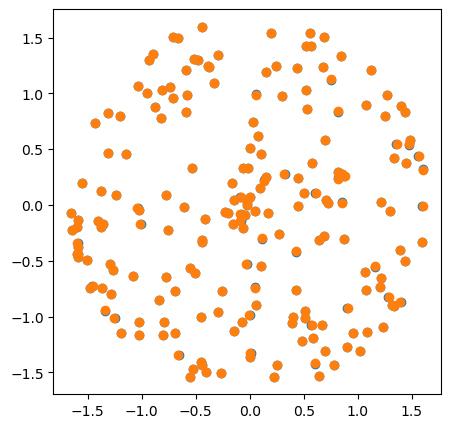

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(*x.numpy())
plt.scatter(*z.numpy())

In [7]:
t = testset[0]['test']
init_pos = t['init_angle'].numpy()
target_pos = t['target_pos'].numpy()
true_pos = t['true_pos'].numpy()
for pos in true_pos:
	print(pos)
	break

[1.26156726 1.08049519]


In [13]:
singular = []
flag = False
for i in range(100):
	t = testset[i]['test']
	init_pos = t['init_angle'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	for pos in true_pos:
		if np.allclose(pos, target_pos):
			flag = True
			break
	if not flag:
		singular.append(i) 
print(len(singular)/100)

0.0


In [14]:
singular

[]

In [15]:
def plot_trace(t):
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[50:,0], true_pos[50:,1], label='true_pos')
	plt.legend()

In [16]:
for i in singular:
	plot_trace(testset[i])